## Notebook 8: Evaluate the trained model ##
Demonstates how to evaluate the trained model from a checkpoint

In [35]:
# Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import glob

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score 
from sklearn.metrics import accuracy_score

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm

# PyTorch packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch import Trainer
import torchmetrics

# Albumentations library
import albumentations as alb

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Appearance of plots
plt.style.use('ggplot')
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import dentexmodel as dm
from dentexmodel.imageproc import ImageData
from dentexmodel.fileutils import FileOP
from dentexmodel.torchdataset import DatasetFromDF, load_and_process_image

print(f'dentexmodel package version:  {dm.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dentexmodel package version:  0.0.post1.dev36+gb44e647.d20240101


In [3]:
# Path settings 
dentex_dir = os.path.join(os.environ['HOME'], 'data', 'dentex')
data_dir = os.path.join(dentex_dir, 'dentex_disease')
image_dir = os.path.join(data_dir, 'quadrant-enumeration-disease', 'xrays', 'crop')
data_file_name = 'dentex_disease_datasplit_cl.parquet'
data_file = os.path.join(dentex_dir, data_file_name)

In [4]:
# %% Package and GPU checks
print(f'PyTorch version:              {torch.__version__}')
print(f'PyTorch Lightning version:    {pl.__version__}')

# Lets run inference on the CPU
device = torch.device("cpu")
torch.set_float32_matmul_precision(precision='high')

PyTorch version:              2.1.2+cu121
PyTorch Lightning version:    2.1.3


### Load the test data ###

In [5]:
data_df = pd.read_parquet(data_file)

# Create the class dictionary from the data frame
label_list = sorted(list(data_df['label'].unique()))
label_cl = [data_df.loc[data_df['label'] == label, 'cl'].values[0] for label in label_list]
label_dict = dict(zip(label_cl, label_list))
display(label_dict)

test_df = data_df.loc[data_df['dataset'] == 'test']

test_samples = sorted(list(test_df['box_name'].unique()))
print(f'Found {len(test_samples)} samples in the test set.')
print()
display(test_df['label'].value_counts())
print()
display(test_df.head())

{0: 'Caries', 1: 'Deep Caries', 2: 'Impacted', 3: 'Periapical Lesion'}

Found 120 samples in the test set.



label
Periapical Lesion    30
Impacted             30
Deep Caries          30
Caries               30
Name: count, dtype: int64

,image_id,file_name,image_number,file_path,quadrant,position,label,area,bbox,box_name,annotations,box_file,im_width,im_height,dataset,cl
7,410,train_59.png,59,/home/andreas/data/dentex/dentex_disease/quadr...,3,6,Periapical Lesion,50805,"[1740.0, 648.0, 252.0, 332.0]",train_59_2154_3_6,6,/home/andreas/data/dentex/dentex_disease/quadr...,252,332,test,3
12,11,train_498.png,498,/home/andreas/data/dentex/dentex_disease/quadr...,1,8,Impacted,20726,"[869.0, 424.0, 222.0, 184.0]",train_498_68_1_8,12,/home/andreas/data/dentex/dentex_disease/quadr...,222,184,test,2
65,525,train_628.png,628,/home/andreas/data/dentex/dentex_disease/quadr...,3,5,Deep Caries,25605,"[1741.5555555555557, 655.3333333333334, 102.77...",train_628_2712_3_5,7,/home/andreas/data/dentex/dentex_disease/quadr...,102,331,test,1
66,413,train_626.png,626,/home/andreas/data/dentex/dentex_disease/quadr...,2,8,Deep Caries,27195,"[2059.6774193548385, 441.258064516129, 150.806...",train_626_2173_2_8,4,/home/andreas/data/dentex/dentex_disease/quadr...,150,238,test,1
70,249,train_365.png,365,/home/andreas/data/dentex/dentex_disease/quadr...,4,6,Periapical Lesion,41905,"[905.0, 850.0, 242.0, 277.0]",train_365_1322_4_6,7,/home/andreas/data/dentex/dentex_disease/quadr...,242,277,test,3


In [25]:
# Create a pytorch data set from the data frame
# Vor validation and testing, we do not want any augmentations
# but we will still need the correct input size and image normalization
# The output of this transformation must match the required input size for the model
max_image_size = 550
im_size = 224
batch_size = 6

# We need the same normalization as we used for training
val_transform = alb.Compose([alb.Resize(im_size, im_size),
                             alb.Normalize(mean=ImageData().image_net_mean, 
                                           std=ImageData().image_net_std)])

# Create the PyTorch dataset
test_dataset = DatasetFromDF(data=test_df,
                             file_col='box_file',
                             label_col='cl',
                             max_image_size=max_image_size,
                             transform=val_transform,
                             validate=True)
# Create a data loader
dl = DataLoader(test_dataset,
                batch_size=batch_size,
                num_workers=0,
                shuffle=False)

### Load the model from a checkpoint ###

In [26]:
# Replace this if you have trained your own model
link = 'https://dsets.s3.amazonaws.com/dentex/toothmodel1_50.ckpt'
checkpoint_file = FileOP().download_from_url(url=link, download_dir=dentex_dir)

File extension is unexpected .ckpt.


File: .ckpt loaded.


### Instantiate the model with weights from checkpoint file ###

In [27]:
from dentexmodel.models.toothmodel_basic import ToothModel
model = ToothModel.load_from_checkpoint(checkpoint_file, map_location=device)
# Initialize a new model just for comparison if we did not train this model
new_model = ToothModel(train_dataset=None,
                       batch_size=batch_size)

In [28]:
# Run one batch of images through the model
sm = nn.Softmax(dim=1)
image_batch, label_batch = next(iter(dl)) 
display(sm(model(image_batch)))

tensor([[4.1182e-01, 3.7793e-01, 2.9613e-04, 2.0996e-01],
        [5.1933e-02, 6.1867e-02, 8.8585e-01, 3.4991e-04],
        [9.2396e-01, 7.5090e-02, 3.4804e-05, 9.1921e-04],
        [6.0066e-01, 9.5907e-02, 3.0340e-01, 3.4179e-05],
        [6.3218e-01, 1.2931e-02, 1.4737e-05, 3.5487e-01],
        [2.0675e-01, 7.8616e-01, 9.3430e-04, 6.1636e-03]],
       grad_fn=<SoftmaxBackward0>)

### Predict on the test set ###
This could be done better with a test_step method. But this works too.

In [29]:
pred_df_batch_list = []
for image_batch, label_batch in dl:
    pred_df_batch = pd.DataFrame(sm(model(image_batch)).detach().numpy()).\
                    assign(cl=list(label_batch.detach().numpy()))
    pred_df_batch_list.append(pred_df_batch)
pred_df = pd.concat(pred_df_batch_list, axis=0, ignore_index=True)
display(pred_df.head())
print()
display(label_dict)

,0,1,2,3,cl
0,0.411816,0.377930,0.000296,0.209957,3
1,0.051933,0.061867,0.885849,0.000350,2
2,0.923956,0.075090,0.000035,0.000919,1
3,0.600663,0.095907,0.303396,0.000034,1
4,0.632182,0.012931,0.000015,0.354872,3


{0: 'Caries', 1: 'Deep Caries', 2: 'Impacted', 3: 'Periapical Lesion'}

### Evaluate model performance as binary classification tasks ###

Performance for class 0: "Caries"
{'precision': 0.5769, 'recall': 1.0, 'threshold': 0.6669999957084656, 'f1': 0.7317}


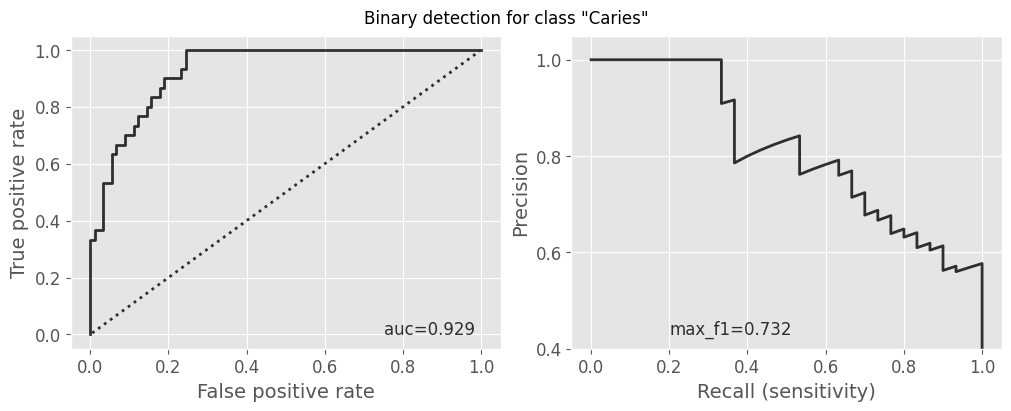


Performance for class 1: "Deep Caries"
{'precision': 1.0, 'recall': 0.5, 'threshold': 0.6498000025749207, 'f1': 0.6667}


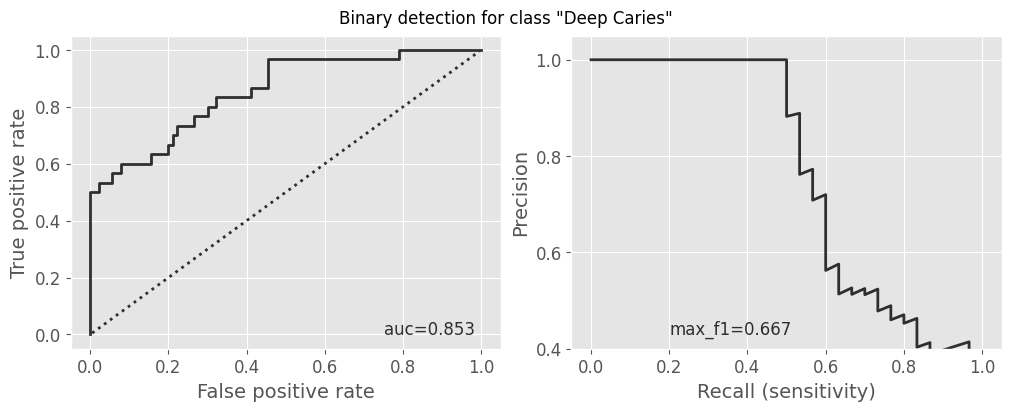


Performance for class 2: "Impacted"
{'precision': 1.0, 'recall': 0.9667, 'threshold': 0.3804999887943268, 'f1': 0.9831}


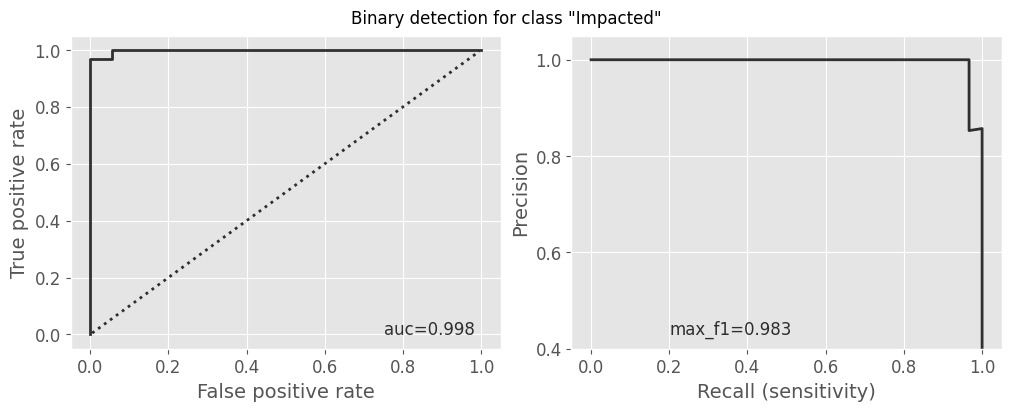


Performance for class 3: "Periapical Lesion"
{'precision': 0.95, 'recall': 0.6333, 'threshold': 0.20090000331401825, 'f1': 0.76}


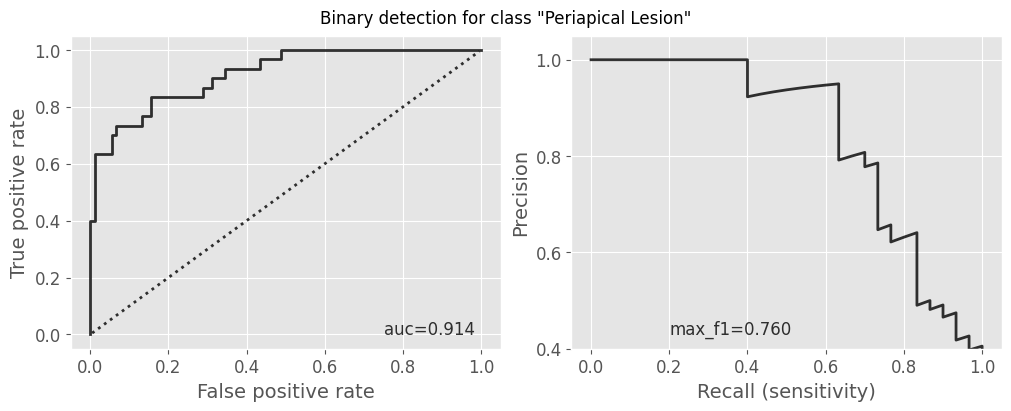

In [30]:
def max_f1_threshold(precision, recall, thr):
    """ Determine the threshold for the maximum f1 score """
    pdf = pd.DataFrame({'precision': np.round(precision, 4),
                        'recall': np.round(recall, 4),
                        'threshold': np.round(thr, 4)})
    pdf = pdf.assign(f1=np.round(2 * (pdf['precision'] * pdf['recall']) / (pdf['precision'] + pdf['recall']), 4))
    max_f1_dict = dict(pdf.loc[pdf['f1'] == pdf['f1'].max()].iloc[0])
    return max_f1_dict
    
def performance_plots(y_true, y_score, cl_name, figsize=(10,5)):
    # Metrics for ROC and P-R curves
    auc = roc_auc_score(y_true=y_true, y_score=y_score)
    fpr, tpr, r_thresholds = roc_curve(y_true=y_true, y_score=y_score)
    precision, recall, p_thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
    max_f1_dict = max_f1_threshold(precision=precision[:-1], recall=recall[:-1], thr=p_thresholds)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, constrained_layout=True)
    # ROC curve
    ax[0].plot(fpr, tpr, color='k', linewidth=2.0, alpha=0.8)
    ax[0].text(x=0.75, y=0, s=f'auc={auc:.3f}', alpha=0.8)
    ax[0].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
              xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0, 1.2, 0.2),
              xlabel='False positive rate', ylabel='True positive rate')
    ax[0].plot([0.05, 0.95], [0.05, 0.95], transform=ax[0].transAxes, color='k', 
               linewidth=2, alpha=0.8, linestyle=':')

    # PR curve
    ax[1].plot(recall, precision, color='k', linewidth=2.0, alpha=0.8)
    ax[1].text(x=0.2, y=0.43, s=f'max_f1={max_f1_dict.get("f1"):.3f}', alpha=0.8)
    ax[1].set(xlim=[-0.05, 1.05], ylim=[0.4, 1.05],
              xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0.4, 1.2, 0.2),
              xlabel='Recall (sensitivity)', ylabel='Precision')

    fig.suptitle(f'Binary detection for class "{cl_name}"', fontsize=12)
    
    return fig, ax

figsize = (10, 4)
for cl, cl_name in list(label_dict.items()):
    y_true = [1 if c == cl else 0 for c in pred_df['cl'].values]
    y_score=pred_df[cl]
    print(f'Performance for class {cl}: "{cl_name}"')
    precision, recall, p_thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
    max_f1_dict = max_f1_threshold(precision=precision[:-1], recall=recall[:-1], thr=p_thresholds)
    print(max_f1_dict)
    fig, ax = performance_plots(y_true=y_true, y_score=y_score, cl_name=cl_name, figsize=figsize)
    plt.show()
    print()